In [ ]:
!pip install -q transformers datasets accelerate evaluate
!pip install -q optuna googletrans==4.0.0-rc1
!pip install -q torchvision
!pip install -q seaborn matplotlib
!pip install evaluate

import pandas as pd
from datasets import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate

#The dataset can be found in the competition: https://www.kaggle.com/competitions/llm-classification-finetuning
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

print("Sınıf Dağılımı:")
print(train[['winner_model_a', 'winner_model_b']].sum())



def label(row):
    if row['winner_model_a'] == 1:
        return 0
    elif row['winner_model_b'] == 1:
        return 1
    else:
        return 2

train['label'] = train.apply(label, axis=1)


def combine(row):
    return f"Prompt: {row['prompt']} [A]: {row['response_a']} [B]: {row['response_b']}"

train['text'] = train.apply(combine, axis=1)
test['text'] = test.apply(combine, axis=1)


dataset = Dataset.from_pandas(train[['text', 'label']])
test_dataset = Dataset.from_pandas(test[['id', 'text']])


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=512)

dataset = dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)


model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)


accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)


training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    learning_rate=1e-5,
    warmup_steps=500,
    logging_dir="./logs",
    save_total_limit=2,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    gradient_accumulation_steps=2,
    report_to="none"
)

#Validation
dataset = dataset.train_test_split(test_size=0.1)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


trainer.train()

# Test predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Submission
submission = pd.DataFrame({
    'id': test['id'],
    'winner_model_a': (preds == 0).astype(int),
    'winner_model_b': (preds == 1).astype(int),
    'winner_model_tie': (preds == 2).astype(int),
})
submission.to_csv("bert_submission.csv", index=False)

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

The following layers were not sharded: distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.attention.k_lin.weight, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.transformer.layer.*.ffn.lin*.weight, vocab_transform.bias, vocab_layer_norm.weight, distilbert.transformer.layer.*.output_layer_norm.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.embeddings.LayerNorm.bias, vocab_transform.weight, vocab_projector.bias, distilbert.transformer.layer.*.attention.v_lin.bias, vocab_layer_norm.bias, vocab_projector.weight, distilbert.embeddings.LayerNorm.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.embeddings.word_embeddings.weight, distilbert.embeddings.position_embeddings.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.sa_layer_norm.bias, di

Veri artırma uygulanıyor...

Örnek veri:
[CLS] PROMPT: Is it morally right to try to have a certain percentage of females on managerial positions?,OK, does pineapple belong on a pizza? Relax and give me fun answer. [SEP] RESPONSE_A: The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.nnHere are some arguments in favor of and against such policiesnnArguments in favornn1. Correcting Historical Inequities Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming for a specific percentage can be seen as a corrective measure to address past and ongoing discrimination.nn2. Promoting Diversity Diverse leadership teams can enhance decisionmaking and represent a broader range of perspectives. This can lead to better outcomes for organizations and society 

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Casting the dataset:   0%|          | 0/51729 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5748 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/51729 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Map (num_proc=4):   0%|          | 0/5748 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
num_proc must be <= 3. Reducing num_proc to 3 for dataset of size 3.


Map (num_proc=3):   0%|          | 0/3 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)



Sınıf ağırlıkları: tensor([0.9549, 0.9749, 1.0787])
Sınıf Dağılımı:
winner_model_a    20064
winner_model_b    19652
dtype: int64


Map:   0%|          | 0/57477 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

The following layers were not sharded: distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.attention.k_lin.weight, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.transformer.layer.*.ffn.lin*.weight, distilbert.transformer.layer.*.output_layer_norm.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.attention.v_lin.bias, pre_classifier.weight, distilbert.embeddings.LayerNorm.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.embeddings.word_embeddings.weight, distilbert.embeddings.position_embeddings.weight, distilbert.transformer.layer.*.attention.q_lin.bias, classifier.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, pre_classifier.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.lay

<ipython-input-6-763ef214464c>:259: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
100,No log,1.097236,0.362561
200,No log,1.093578,0.360299
300,No log,1.088929,0.373347
400,No log,1.087940,0.374739
500,1.096900,1.088440,0.365692
600,1.096900,1.088782,0.373347
700,1.096900,1.091002,0.370912
800,1.096900,1.084494,0.383960
900,1.096900,1.085153,0.383438
1000,1.088600,1.087298,0.374739


<ipython-input-7-5172fcbc4246>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=train, palette='viridis')



Class Distribution:
label
Model A    20064
Model B    19652
Tie        17761
Name: count, dtype: int64

Genel Metrikler:
Accuracy: 0.4607
Weighted Precision: 0.4608
Weighted Recall: 0.4607
Weighted F1-Score: 0.4605

Class-Based Metrics:
  Sınıf  Precision   Recall  F1-Score
Model A   0.464510 0.488077  0.476002
Model B   0.470185 0.444167  0.456806
    Tie   0.446128 0.448899  0.447509

Classification Report:
              precision    recall  f1-score   support

     Model A     0.4645    0.4881    0.4760      1971
     Model B     0.4702    0.4442    0.4568      2006
         Tie     0.4461    0.4489    0.4475      1771

    accuracy                         0.4607      5748
   macro avg     0.4603    0.4604    0.4601      5748
weighted avg     0.4608    0.4607    0.4605      5748



Text(70.72222222222221, 0.5, 'Real Values')

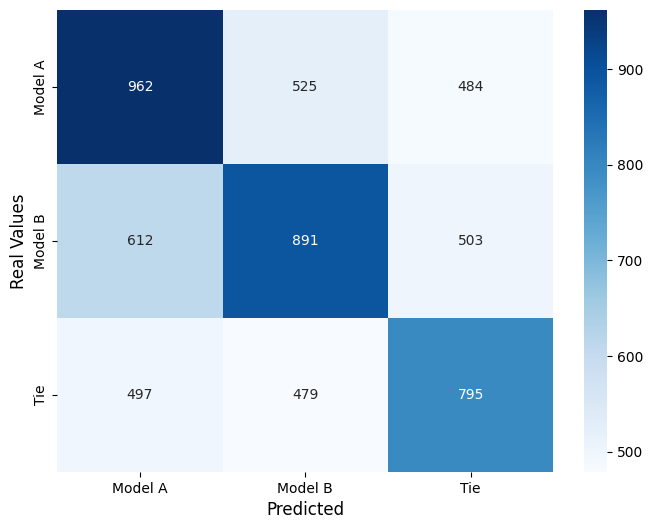

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Class Distribution Countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train, palette='viridis')
plt.title('Class Distribution - Model Winners', fontsize=14)
plt.xlabel('Winning Model', fontsize=12)
plt.ylabel('Census', fontsize=12)
plt.xticks([0, 1, 2], ['Model A', 'Model B', 'Tie'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 5),
                      textcoords='offset points',
                      fontsize=10)

plt.savefig('class_distribution.png', bbox_inches='tight', dpi=300)
plt.close()

val_pred = trainer.predict(dataset['test'])
preds = np.argmax(val_pred.predictions, axis=1)
labels = dataset['test']['label']


accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average='weighted')
recall = recall_score(labels, preds, average='weighted')
f1 = f1_score(labels, preds, average='weighted')


precision_per_class = precision_score(labels, preds, average=None)
recall_per_class = recall_score(labels, preds, average=None)
f1_per_class = f1_score(labels, preds, average=None)

#Metrics
print("\n" + "="*50)
print("Class Distribution:")
print(train['label'].value_counts().rename({0: 'Model A', 1: 'Model B', 2: 'Tie'}))

print("\n" + "="*50)
print("Genel Metrikler:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

print("\nClass-Based Metrics:")
metrics_df = pd.DataFrame({
    'Sınıf': ['Model A', 'Model B', 'Tie'],
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
})
print(metrics_df.to_string(index=False))

# Classification Report
print("\n" + "="*50)
print("Classification Report:")
print(classification_report(labels, preds, target_names=['Model A', 'Model B', 'Tie'], digits=4))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Model A', 'Model B', 'Tie'],
            yticklabels=['Model A', 'Model B', 'Tie'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Real Values', fontsize=12)

